<a href="https://colab.research.google.com/github/Sumirsht/GEDI/blob/main/GEDI_L4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Searching and Downloading GEDI L4A Dataset**

This tutorial will demonstrate how to search and download Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) dataset. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit.

We will use NASA's Earthdata Common Metadata Repository (CMR) Application Programming Interface (API) to search for GEDI L4A files or granules for time and area of interest. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access. Area of interest can be defined using a bounding box (Option 1) or using polygons (Option 2).

This tutorial requires the following Python modules installed in your system: requests, datetime, pandas, geopandas, shapely. Requirements are also in requirements.txt. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:

pip install -r requirements.txt

In [1]:
%matplotlib inline
import requests
import datetime as dt
import pandas as pd
import geopandas as gpd
!pip install contextily # Corrected the pip install command
import contextily as ctx
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient

1. Searching with a bounding box (Option 1)
NASA EarthData's unique ID for this dataset (called Concept ID) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the Concept ID.

In [2]:
doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

print(concept_id)

C2237824918-ORNL_CLOUD


In [3]:
# Nepal bounding box
bound = (80.058, 26.347, 88.201, 30.422)

# time bound
start_date = dt.datetime(2022, 1, 1) # specify your own start date
end_date = dt.datetime(2023, 1, 31)  # specify your end start date

This is the unique NASA-given concept ID for the GEDI 4A dataset, which can be used to retrieve relevant files (or granules) for GEDI L4A. For this tutorial, let's use a bounding box of Nepal, which extends north to south from (80.058, 26.347, 88.201, 30.422). We will download all the files for Janurary, 2022.

In [4]:
# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }

    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    response.raise_for_status()
    granules = response.json()['feed']['entry']

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''

            # read file size
            granule_size = float(g['granule_size'])

            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])])

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  383
Total file size (MB):  129872.17096799999


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe l4adf. The first few rows of the table look like the following

In [5]:
l4adf.head()

granule_url  granule_size  \
0  https://data.ornldaac.earthdata.nasa.gov/prote...    311.808471   
1  https://data.ornldaac.earthdata.nasa.gov/prote...    358.155074   
2  https://data.ornldaac.earthdata.nasa.gov/prote...    306.037030   
3  https://data.ornldaac.earthdata.nasa.gov/prote...    376.193487   
4  https://data.ornldaac.earthdata.nasa.gov/prote...    312.192071   

                                        granule_poly  
0  MULTIPOLYGON (((17.0472622 51.7567062, 23.0223...  
1  MULTIPOLYGON (((57.3941078 -0.34812, 59.552349...  
2  MULTIPOLYGON (((23.2352562 51.7570953, 29.2164...  
3  MULTIPOLYGON (((63.5152702 -0.278396, 65.67452...  
4  MULTIPOLYGON (((17.8298073 51.7560692, 23.8136...

We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The bounding box (of Lumbini) is plotted in red color.

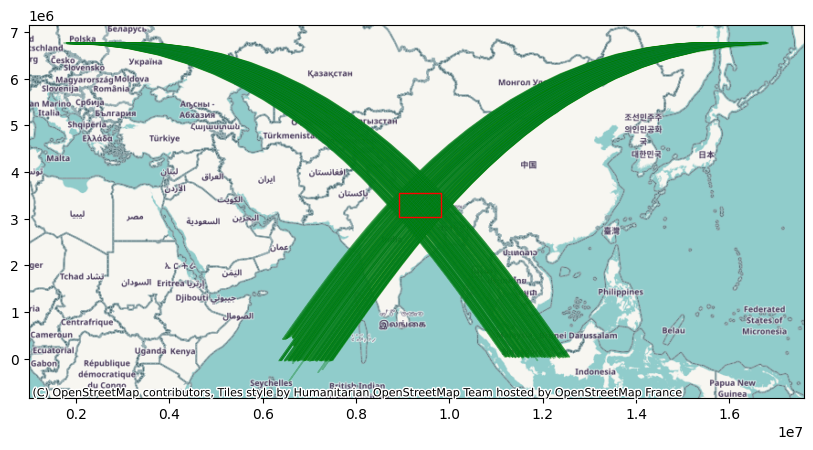

In [6]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits
ax=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')
# adding to contextily basemap
ctx.add_basemap(ax)

2. Searching for a polygonal area of interest (Option 2)
If an area of interest is already defined as a polygon, the polygon file (geojson, shapefile or kml) can be used to find overlapping GEDI L4A files. More details about this capability are described in this page.

For this tutorial, we will use the boundary of a northern states of TAL to search for the overlapping GEDI files. The boundary polygon is stored in a geojson file called amapa.json (shown in red polygon in the figure below).

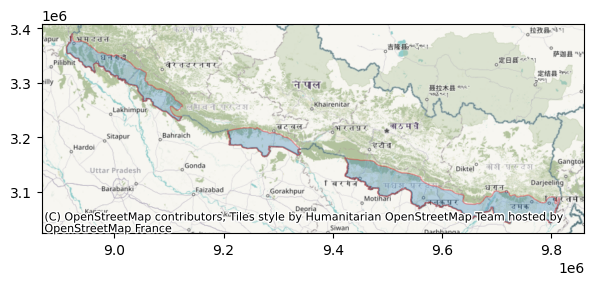

In [7]:
!pip install shapely --upgrade
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import orient # Correct import for orient
import zipfile

# Path to the zip file
zip_file_path = "/content/Terai.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, "r") as z:
    z.extractall("shapefile")  # Extract to the "shapefile" directory
import geopandas as gpd

import contextily as ctx

# Path to the shapefile (adjust the file name if needed)
# Use the actual file name extracted from the zip
# The 'list' method can help you see file names in zip file:
#    print(z.namelist())
shapefile_path = "shapefile/Terai.shp" # This line needs review

# Load the shapefile
Terai = gpd.read_file(shapefile_path)

# Ensure geometries are consistently oriented
Terai.geometry = Terai.geometry.apply(orient, args=(1,))

# Plot the shapefile with a basemap
ax = Terai.to_crs(epsg=3857).plot(figsize=(7, 7), alpha=0.3, edgecolor="red")
ctx.add_basemap(ax)

In this example, we will search for all the GEDI L4A files available for the area using the CMR API.

In [8]:
doi = '10.3334/ORNLDAAC/2056'  # GEDI L4A DOI

# CMR API base url
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

# Simplify the geometry before sending it to the API
# This reduces the number of coordinates and the size of the request.
# Adjust the tolerance value as needed to balance simplification and accuracy.
simplified_geometry = Terai.geometry.simplify(tolerance=0.01)
geojson = {"shapefile": ("Terai.shp", simplified_geometry.to_json(), "application/geo+json")}


page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true'  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)

    # Check for errors and print the response content if there's an issue
    try:
        response.raise_for_status()
        granules = response.json()['feed']['entry']
    except requests.exceptions.HTTPError as e:
        print(f"Error: {e}")
        print(f"Response content: {response.content}")  # Print the response content for debugging
        break

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''

            # read file size
            granule_size = float(g['granule_size'])

            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['Terai', 0, Terai.geometry.iloc[0] ])

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  760
Total file size (MB):  255570.118824


In [9]:
l4adf.head()

granule_url  granule_size  \
0  https://data.ornldaac.earthdata.nasa.gov/prote...    327.606674   
1  https://data.ornldaac.earthdata.nasa.gov/prote...    364.342445   
2  https://data.ornldaac.earthdata.nasa.gov/prote...    294.187984   
3  https://data.ornldaac.earthdata.nasa.gov/prote...    341.324672   
4  https://data.ornldaac.earthdata.nasa.gov/prote...    382.521629   

                                        granule_poly  
0  MULTIPOLYGON (((22.9855709 51.7780952, 28.9771...  
1  MULTIPOLYGON (((63.2038345 0.030941, 65.364334...  
2  MULTIPOLYGON (((19.4547024 51.8211517, 25.4535...  
3  MULTIPOLYGON (((60.3164864 0.960009, 62.480228...  
4  MULTIPOLYGON (((66.3303604 -0.01988, 68.491142...

We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The TAl state is plotted in red color.

In [10]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits bounding geometry
ax=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')
# adding to contextily basemap
ctx.add_basemap(ax)

3. Downloading the files

We recommend using utilities such as cURL or wget to download the files. You will first need to set up NASA Earthdata Login authentication using .netrc file. Please refer to this page for details on setting up such authentication: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

Once the authentication has been setup (Steps 1-3 on the above page), the GEDI L4a files can be downloaded as follows.

First, save the granule URLs to a file granules.txt.

In [11]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

Either of the following commands can then be issued from the terminal to download the files.

wget
wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i granules.txt

curl
cat granules.txt | tr -d '\r' | xargs -n 1 curl -LJO -n -c ~/.urs_cookies -b ~/.urs_cookies

**Subsetting GEDI L4A Footprints**

This tutorial will demonstrate how to subset Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) dataset to a study area of interest. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit.

The previous tutorial explains how to download GEDI L4A files for a study area of interest (bounding box or polygon) and a specific period. Once all the GEDI L4A files are downloaded, the global orbits of GEDI L4A can be clipped or subsetted to the study area of interest.

This tutorial requires the following Python modules installed in your system: requests, numpy, h5py, datetime, pandas, geopandas, contextily, shapely. Requirements are also in requirements.txt. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:

pip install -r requirements.txt

In [12]:
%matplotlib inline
import requests
import h5py
import pandas as pd
import geopandas as gpd
import contextily as ctx
import h5py
import numpy as np
from glob import glob
from os import path
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient

**1. Polygonal Area of Interest**

We will use the boundary of the Terai Arc Landscape to demonstrate the spatial subsetting process. The boundary file is in ESRI Shapefile format in the folder called TAL. Let's read the boundary file and print out its coordinate system.

In [13]:
Terai_poly = gpd.read_file('/content/shapefile/Terai.shp')
Terai_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

 Now let's plot our study area over a base map. First, we will convert to Tal polygon into Web Mercator (EPSG 3857) to bring it to the same coordinate reference system as the base map. If it's in same web mercator don't need to change it.

In [14]:
Terai_epsg3857 = Terai_poly.to_crs(epsg=3857)
ax=Terai_epsg3857.plot(figsize=(10, 5), alpha=0.3, edgecolor='red')
ctx.add_basemap(ax)

In [15]:
# converting to WGS84 coordinate system
Terai_epsg4326 = Terai_poly.to_crs(epsg=4326)

# orienting coordinates clockwise
Terai_epsg4326.geometry = Terai_epsg4326.geometry.apply(orient, args=(1,))

# reducing number of vertices in the polygon
# CMR has 1000000 bytes limit
Terai_epsg4326 = Terai_epsg4326.simplify(0.0005)

doi = '10.3334/ORNLDAAC/2056'  # GEDI L4A DOI

# CMR API base url
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

# Simplify the geometry before sending it to the API
# This reduces the number of coordinates and the size of the request.
# Adjust the tolerance value as needed to balance simplification and accuracy.
simplified_geometry = Terai.geometry.simplify(tolerance=0.01)
geojson = {"shapefile": ("Terai.shp", Terai_epsg4326.geometry.to_json(), "application/geo+json")}


page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true'  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)

    # Check for errors and print the response content if there's an issue
    try:
        response.raise_for_status()
        granules = response.json()['feed']['entry']
    except requests.exceptions.HTTPError as e:
        print(f"Error: {e}")
        print(f"Response content: {response.content}")  # Print the response content for debugging
        break

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''

            # read file size
            granule_size = float(g['granule_size'])

            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['Terai', 0, Terai_epsg4326.geometry.iloc[0] ])

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  761
Total file size (MB):  255912.09507600003


In [16]:

gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax=gdf_epsg3857[:3].plot(figsize=(10, 5),edgecolor='green')
ctx.add_basemap(ax)


Each GEDI L4A file extends beyond the study area of interest. Now, let's plot a zoomed-in version of the above map over GRSM.

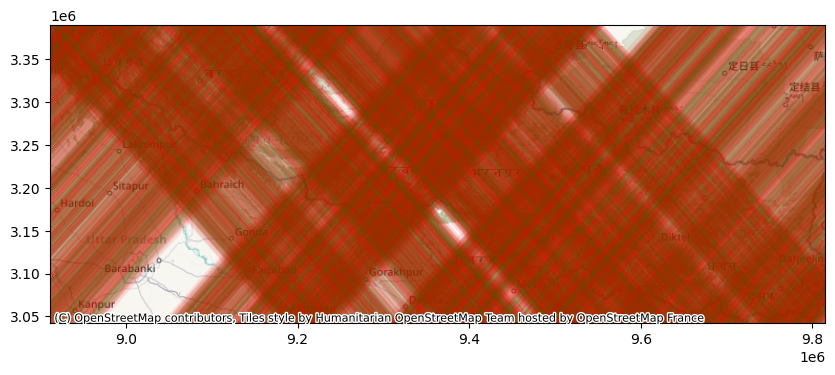

In [17]:
ax2=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.1, color='green', edgecolor='red', linewidth=5)
minx, miny, maxx, maxy = Terai_epsg3857.total_bounds
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)
ctx.add_basemap(ax2)

As we see in the figures above, GEDI has a good coverage over the TAL area.

**3. Downloading the GEDI L4A files**

We will now save the granule URLS into a file granules.txt and use wget command in the terminal to download all the 136 files. Please refer to the previous tutorial for more details on downloading programmatically.

In [18]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

**4. Subsetting the GEDI L4A files**

Once all the GEDI L4A files are downloaded, we can clip the full orbit files to retrieve the footprints that fall within the area of interest, i.e. GRSM boundary. We have downloaded all the files to a folder called full_orbits for this tutorial.

**4a. Exploring the data structure**

Let's first open one of the L4A file GEDI04_A_2019108015253_O01960_02_T03910_02_002_02_V002.h5 we just downloaded and print the root-level variable group.

In [19]:
hf = h5py.File('/content/full_orbits/GEDI04_A_2023037032903_O23515_02_T03206_02_003_01_V002.h5', 'r')
hf.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

All science variables are organized by eight beams of the GEDI. Please refer to the GEDI L4A user guide and GEDI L4A data dictionary for details on file organization. Let's look into one of the beam group BEAM0110 and print all the science dataset (SDS) variables within the group.

In [20]:
beam0110 = hf.get('BEAM0110')
beam0110.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In the above list of variables, 2 science dataset (SDS) are particulary useful for spatial subsetting: lat_lowestmode and lon_lowestmode, which represent ground location of each GEDI shot.

Let's plot all the beams in the map.

In [21]:
lat_l = []
lon_l = []
beam_n = []
for var in list(hf.keys()):
    if var.startswith('BEAM'):
        beam = hf.get(var)
        lat = beam.get('lat_lowestmode')[:]
        lon = beam.get('lon_lowestmode')[:]
        lat_l.extend(lat.tolist()) # latitude
        lon_l.extend(lon.tolist()) # longitude
        n = lat.shape[0] # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())
geo_arr = list(zip(beam_n,lat_l,lon_l))
l4adf = pd.DataFrame(geo_arr, columns=["beam", "lat_lowestmode", "lon_lowestmode"])
l4adf

beam  lat_lowestmode  lon_lowestmode
0        BEAM0000       -0.092032       63.508006
1        BEAM0000       -0.091610       63.508303
2        BEAM0000       -0.091188       63.508600
3        BEAM0000       -0.090767       63.508897
4        BEAM0000       -0.090345       63.509194
...           ...             ...             ...
1338701  BEAM1011       51.776079      147.321797
1338702  BEAM1011       51.776076      147.322595
1338703  BEAM1011       51.776085      147.323447
1338704  BEAM1011       51.776088      147.324272
1338705  BEAM1011       51.776096      147.326747

[1338706 rows x 3 columns]

The pandas dataframe l4adf contains beam names, latitude and longitude columns. This particular GEDI orbit recorded a total of 1,338,249 shots. Now we can convert l4adf to a geopandas dataframe l4agdf and clip the file by the boundary of the GRSM.

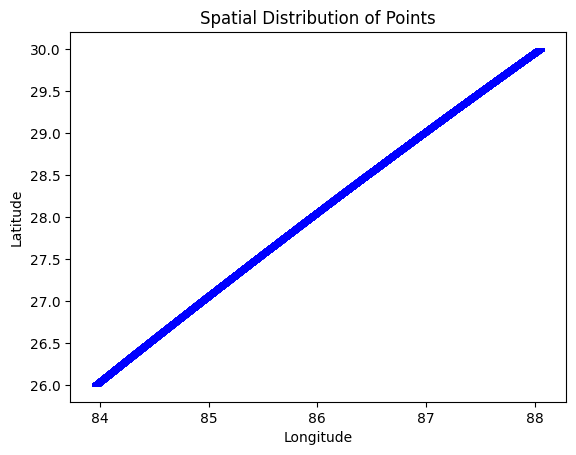

In [22]:
l4adf = l4adf[(l4adf['lat_lowestmode'] >= 26) & (l4adf['lat_lowestmode'] <= 30) &
              (l4adf['lon_lowestmode'] >= 80) & (l4adf['lon_lowestmode'] <= 89)]
import matplotlib.pyplot as plt

plt.scatter(l4adf['lon_lowestmode'], l4adf['lat_lowestmode'], s=1, color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Points')
plt.show()


In [23]:
print(Terai_epsg4326.crs)
print(l4adf)


EPSG:4326
             beam  lat_lowestmode  lon_lowestmode
63130    BEAM0000       26.000255       83.932309
63131    BEAM0000       26.000644       83.932684
63132    BEAM0000       26.001032       83.933058
63133    BEAM0000       26.001421       83.933433
63134    BEAM0000       26.001810       83.933808
...           ...             ...             ...
1245020  BEAM1011       29.998318       88.078213
1245021  BEAM1011       29.998696       88.078618
1245022  BEAM1011       29.999072       88.079023
1245023  BEAM1011       29.999450       88.079428
1245024  BEAM1011       29.999825       88.079834

[83268 rows x 3 columns]


In [24]:
l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
l4agdf.crs = "EPSG:4326"
l4agdf = l4agdf.to_crs(Terai_epsg4326.crs)
print(l4agdf)
#4agdf_terai = l4agdf[l4agdf['geometry'].within(Terai_epsg4326.geometry.iloc[0])]
#print(l4agdf_terai)


             beam  lat_lowestmode  lon_lowestmode                   geometry
63130    BEAM0000       26.000255       83.932309  POINT (83.93231 26.00025)
63131    BEAM0000       26.000644       83.932684  POINT (83.93268 26.00064)
63132    BEAM0000       26.001032       83.933058  POINT (83.93306 26.00103)
63133    BEAM0000       26.001421       83.933433  POINT (83.93343 26.00142)
63134    BEAM0000       26.001810       83.933808  POINT (83.93381 26.00181)
...           ...             ...             ...                        ...
1245020  BEAM1011       29.998318       88.078213  POINT (88.07821 29.99832)
1245021  BEAM1011       29.998696       88.078618   POINT (88.07862 29.9987)
1245022  BEAM1011       29.999072       88.079023  POINT (88.07902 29.99907)
1245023  BEAM1011       29.999450       88.079428  POINT (88.07943 29.99945)
1245024  BEAM1011       29.999825       88.079834  POINT (88.07983 29.99983)

[83268 rows x 4 columns]


In [31]:
print(l4agdf_terai)

Empty GeoDataFrame
Columns: [beam, lat_lowestmode, lon_lowestmode, geometry]
Index: []


In [25]:
print(l4agdf.crs)
print(Terai_epsg4326.crs)
print(l4agdf.is_valid.all())  # Should return True
print(Terai_epsg4326.is_valid.all())  # Should return True
print(l4agdf.geometry.head())
print(Terai_epsg4326.geometry[0])


EPSG:4326
EPSG:4326
True
True
63130    POINT (83.93231 26.00025)
63131    POINT (83.93268 26.00064)
63132    POINT (83.93306 26.00103)
63133    POINT (83.93343 26.00142)
63134    POINT (83.93381 26.00181)
Name: geometry, dtype: geometry
POLYGON ((81.95683788949964 27.914775065865136, 81.93203642210541 27.917537875677276, 81.91504353803457 27.916180891931475, 81.88949294993427 27.917917131303863, 81.86646082504244 27.923121222434787, 81.84204402204965 27.93380649404622, 81.82300746152258 27.94616958699657, 81.80962681464311 27.959289964609418, 81.78602333438954 27.995888925573585, 81.77796133735104 28.01390304534055, 81.76872340580483 28.039686983704847, 81.7664800489504 28.049515450998577, 81.77323494308452 28.061301505016218, 81.79029861351677 28.059709246124374, 81.80797270455948 28.05284126447479, 81.8539869388486 28.018830795228066, 81.86840408618174 28.00571557549398, 81.8957380990837 28.006529082661487, 81.90818144603656 28.0183937015899, 81.92589533281829 28.02389601655134, 81.9

The geopandas dataframe l4agdf_tal contains the shots (3588 shots in total) that fall within the TAL boundary. Now, let's plot these into a map.

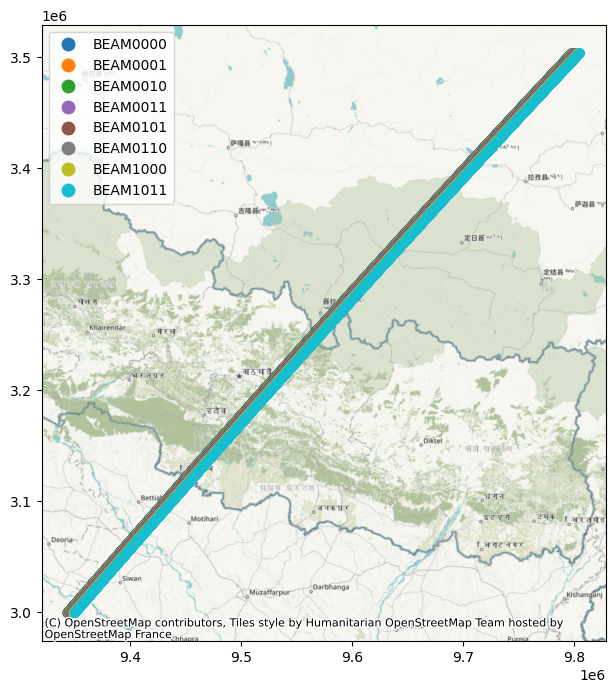

In [26]:
l4agdf_terai_epsg3857 = l4agdf.to_crs(epsg=3857)
ax2=l4agdf_terai_epsg3857.plot(column='beam', legend=True, figsize=(10, 8))
ctx.add_basemap(ax2)

The above map shows the swath coverage of GEDI - a typical swath is ~4200m wide. GEDI instrument produces eight ground tracks plotted in the map with different colors. Let's zoom in into an area and look at the locations of actual shots.

In [27]:
minx1, miny1, maxx1, maxy1 = [9300000, 3000000, 9715000, 3350000]
ax3=l4agdf_terai_epsg3857.plot(column='beam', legend=True, figsize=(8, 10))
ax3.set_xlim(minx1, maxx1)
ax3.set_ylim(miny1, maxy1)
ctx.add_basemap(ax3)

# close the opened hdf5 file
hf.close()

**4b. Subsetting all downloaded files**

In the Steps 2 and 3 above, we downloaded L4A files into the directory full_orbits. We will now loop over each of these files and create a clipped version of the files into a new directory subsets.

In [28]:
import os
from glob import glob
from os import path
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient

indir = 'full_orbits'
outdir = 'subsets'

# Check if 'subsets' exists and handle the case if it's not a directory
if os.path.exists(outdir):
    if not os.path.isdir(outdir):
        # If it's a file, rename it or delete it (be cautious with deleting)
        # Here, we'll rename it by adding "_old" to the name
        os.rename(outdir, outdir + "_old")
    # If 'subsets' was a file, it is now renamed, so create a directory
    # Also, if 'subsets' was already a directory, creating again will not cause errors.
    os.makedirs(outdir, exist_ok=True)
else:
    # If it doesn't exist, create it
    os.makedirs(outdir)

# converting to WGS84 coordinate system
Terai_epsg4326 = Terai_poly.to_crs(epsg=4326)


for infile in glob(path.join(indir, 'GEDI04_A*.h5')):
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')

    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)

    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            # find the shots that overlays the area of interest (TAL)
            lat = beam['lat_lowestmode'][:]
            lon = beam['lon_lowestmode'][:]
            i = np.arange(0, len(lat), 1) # index
            geo_arr = list(zip(lat,lon, i))
            l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
            l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            l4agdf.crs = "EPSG:4326"
            #l4agdf_tal = l4agdf[l4agdf['geometry'].within(tal_epsg4326.geometry[0])]
            indices = l4agdf.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + '/' + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    hf_in.close()
    hf_out.close()

Now, new the subset files are created in the subsets directory. We will use the subset files to create a map of above ground biomass density (the variable agbd inside BEAMXXXX groups) of the TAL.

In [29]:
lat_l = []
lon_l = []
agbd = []
outdir = 'subsets'
for subfile in glob(path.join(outdir, 'GEDI04_A*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist())
            lon_l.extend(beam['lon_lowestmode'][:].tolist())
            agbd.extend(beam['agbd'][:].tolist())
    hf_in.close()
geo_arr = list(zip(agbd,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode))
gdf

agbd  lat_lowestmode  lon_lowestmode                    geometry
0       -9999.0       51.820725       23.245468   POINT (23.24547 51.82072)
1       -9999.0       51.820722       23.246294   POINT (23.24629 51.82072)
2       -9999.0       51.820718       23.247120   POINT (23.24712 51.82072)
3       -9999.0       51.820715       23.247947   POINT (23.24795 51.82071)
4       -9999.0       51.820711       23.248774   POINT (23.24877 51.82071)
...         ...             ...             ...                         ...
2675177 -9999.0       51.776079      147.321797   POINT (147.3218 51.77608)
2675178 -9999.0       51.776076      147.322595   POINT (147.3226 51.77608)
2675179 -9999.0       51.776085      147.323447  POINT (147.32345 51.77609)
2675180 -9999.0       51.776088      147.324272  POINT (147.32427 51.77609)
2675181 -9999.0       51.776096      147.326747   POINT (147.32675 51.7761)

[2675182 rows x 4 columns]

In the above table, we see there are some shots with fill value (-9999). We will exclude these shots in the map below. The following is a map of aboveground biomass density (Mg/ha) or agbd.

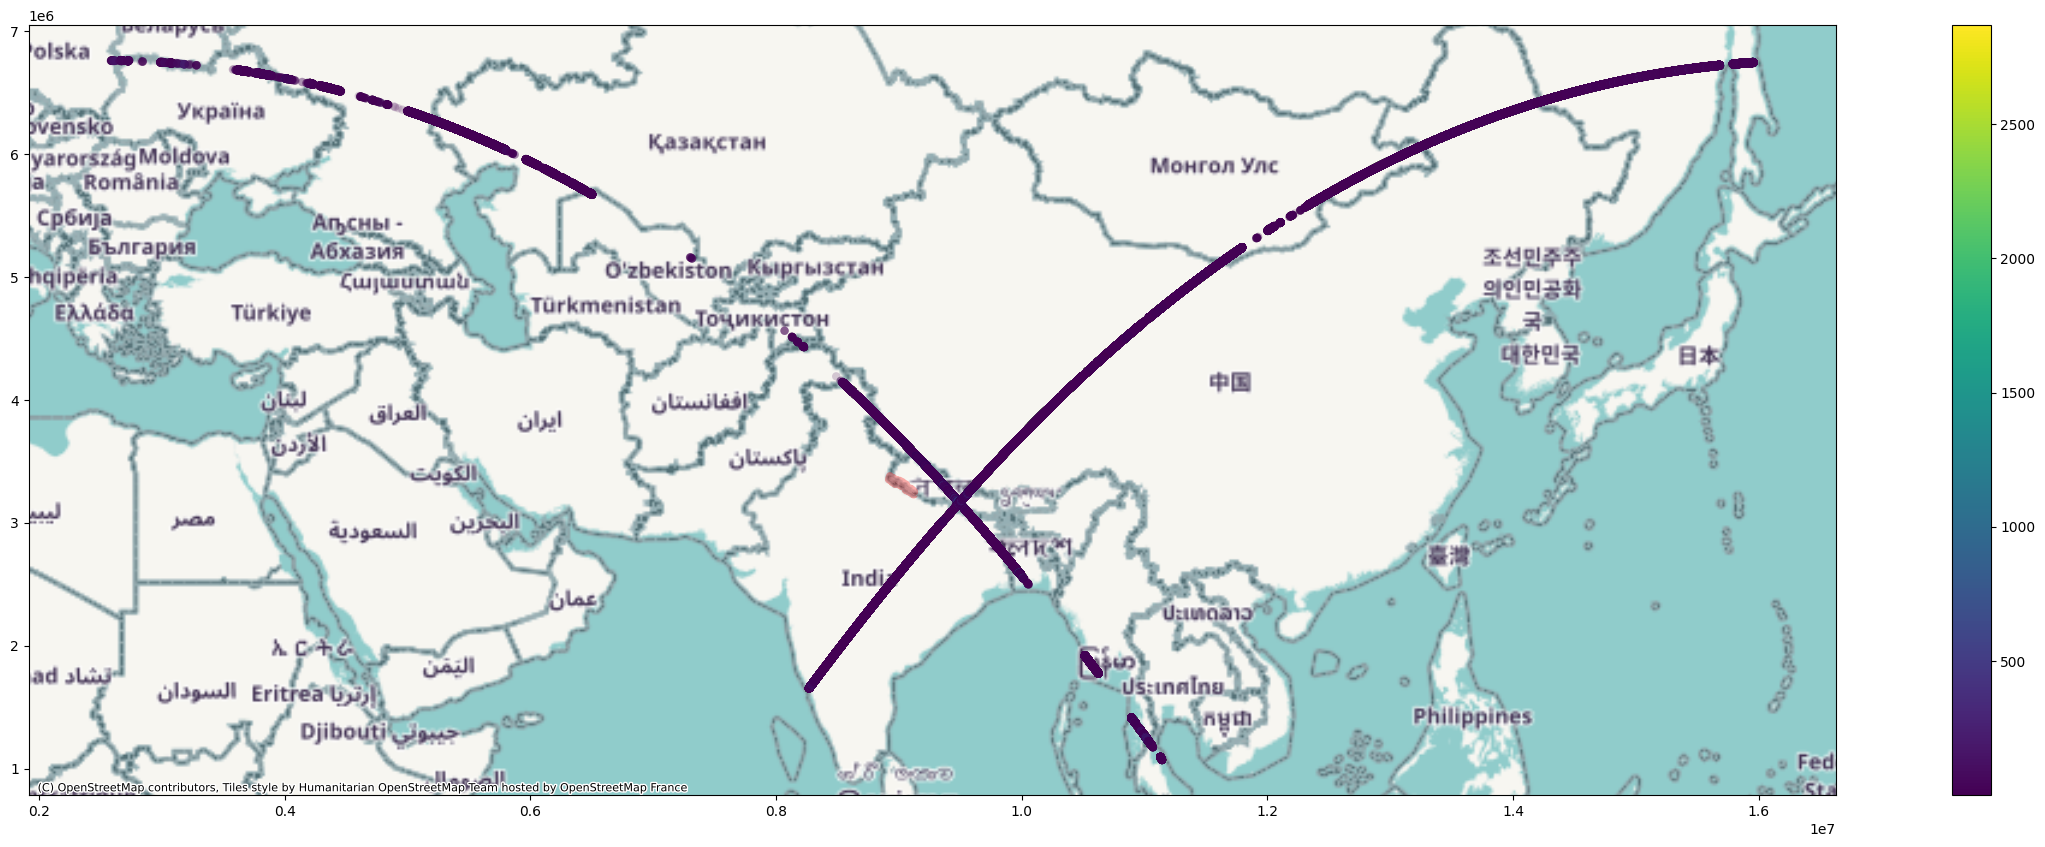

In [30]:
terai_df = pd.DataFrame([[-9999,0,-9999,-9999, Terai_epsg4326.geometry.iloc[0]]], columns=["agbd", "l4_quality_flag","lat_lowestmode", "lon_lowestmode", "geometry"])
gdf = pd.concat([gdf, terai_df])
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax4=gdf_epsg3857[-1:].plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(30, 10))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax4, column='agbd', alpha=0.1, linewidth=0, legend=True)
ctx.add_basemap(ax4)

**4c. Saving the subsets to different formats**

In the step above, we created a HDF5 formatted output, which is the native format of GEDI L4A datasets. The HDF5 files can be output to geojson or csv or ESRI Shapefile using the geopandas.

In [32]:
outdir = 'subsets'
subset_df = pd.DataFrame()
for subfile in glob(path.join(outdir, 'GEDI04_A*_sub.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            col_names = []
            col_val = []
            beam = hf_in[v]
            # copy BEAMS
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if (key2 != "shot_number"):
                             # xvar variables have 2D
                            if (key2.startswith('xvar')):
                                for r in range(4):
                                    col_names.append(key2 + '_' + str(r+1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())

                #looping through base group
                else:
                    # xvar variables have 2D
                    if (key.startswith('xvar')):
                        for r in range(4):
                            col_names.append(key + '_' + str(r+1))
                            col_val.append(value[:, r].tolist())
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())

            # create a pandas dataframe
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
            # Inserting BEAM names
            beam_df.insert(0, 'BEAM', np.repeat(str(v), len(beam_df.index)).tolist())
            # Appending to the subset_df dataframe
            subset_df = pd.concat([subset_df, beam_df])

    hf_in.close()

Now, all the variables are stored in a pandas dataframe subset_df. We can print the dataframe.

In [1]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
subset_df = subset_df.set_index('shot_number')
subset_df.head()

NameError: name 'subset_df' is not defined

The dataframe has 204 columns representing GEDI L4A variables. We can export it to a CSV file directly as:

In [ ]:
subset_df.to_csv('subsets/TAL_subset.csv') # Export to CSV

If we want to save the file as one of the geospatial formats (such as GEOJSON, KML, ESRI Shapefile), we need to first convert the dataframe into a geopandas dataframe, and export to various formats.

In [ ]:
subset_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
subset_gdf.crs = "EPSG:4326"

# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == 'object':
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
#subset_gdf.to_file('subsets/tal_subset.geojson', driver='GeoJSON')
# Export to ESRI Shapefile
subset_gdf.to_file('subsets/tal_subset.shp')

<ipython-input-38-caf946aa1e06>:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subset_gdf.to_file('subsets/tal_subset.shp')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'shot_number' to 'shot_numbe'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'agbd_pi_lower' to 'agbd_pi_lo'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'agbd_pi_upper' to 'agbd_pi_up'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'agbd_pi_lower_a1' to 'agbd_pi__1'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'agbd_pi_lower_a10' to 'agbd_pi__2'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/py